In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import datatable as dt

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_validate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer, roc_auc_score,accuracy_score, roc_curve
from scipy.stats import ks_2samp
from treeinterpreter import treeinterpreter as ti
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('converted_data.csv',sep=',',header=0)
df.head(3)

,age,joined_getsafe_at,language,channel,first_product,zip_bucket,area_classification,most_used_os,buying_platform,converted
0,51,2020-04-21 18:19:07,de,paid_social,legal,539xx,rural,Android,web,1
1,18,2020-08-09 20:14:37,de,direct,liability,305xx,urban,Android,app,1
2,20,2020-08-03 00:51:27,de,aggregator,liability,882xx,rural,Android,app,1


In [3]:
df.shape

(6000, 10)

## Data preprocessing

Checking data types

In [4]:
df.dtypes

age                     int64
joined_getsafe_at      object
language               object
channel                object
first_product          object
zip_bucket             object
area_classification    object
most_used_os           object
buying_platform        object
converted               int64
dtype: object

We need to convert joined_getsafe_at to date format

In [5]:
df['joined_getsafe_at'] = df['joined_getsafe_at'].astype('datetime64')


Let's check for missing values

In [6]:
# Define a function to visulize the features with missing values, and % of total values, & datatype
def missing_values_table(df):
     # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)
        
     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [7]:
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values,type
buying_platform,2872,47.9,object
most_used_os,586,9.8,object
area_classification,19,0.3,object


There are 3 variables with missing values 'Most used OS' and 'Area Classification' have very small percentage of missing data. 'Buying platform' has 48% of missing values. We will analyse this variable and decide how to label the missing values.  

## Feature Engineering

First, let's extract year and month from joined date.

In [8]:
df['Year'] = df['joined_getsafe_at'].apply(lambda x: x.year)
df['Month'] = df['joined_getsafe_at'].apply(lambda x: x.month)

In [9]:
df['Hour'] = df['joined_getsafe_at'].apply(lambda x: x.hour)
df['DayNumber'] = df['joined_getsafe_at'].apply(lambda x: x.weekday())

We need to convert day number to day names

In [10]:
day_numbers = np.unique(df['DayNumber'])
day_numbers

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [11]:
target_names = pd.Series(day_numbers).map({0: 'Monday',1:'Tuesday',2:'Wednesday',
                                        3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})


In [12]:
df['Day'] = df['DayNumber'].apply(lambda x: target_names[x])

In [13]:
df.head(3)

,age,joined_getsafe_at,language,channel,first_product,zip_bucket,area_classification,most_used_os,buying_platform,converted,Year,Month,Hour,DayNumber,Day
0,51,2020-04-21 18:19:07,de,paid_social,legal,539xx,rural,Android,web,1,2020,4,18,1,Tuesday
1,18,2020-08-09 20:14:37,de,direct,liability,305xx,urban,Android,app,1,2020,8,20,6,Sunday
2,20,2020-08-03 00:51:27,de,aggregator,liability,882xx,rural,Android,app,1,2020,8,0,0,Monday


## Exploratory Data Analysis

In [14]:
df['joined_getsafe_at'].describe()

<ipython-input-14-3a9bb464d734>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['joined_getsafe_at'].describe()


count                    6000
unique                   5783
top       2020-03-01 23:15:24
freq                        3
first     2020-01-01 04:05:25
last      2020-10-31 22:30:02
Name: joined_getsafe_at, dtype: object

There are 5,783 unique dates. The first customer that joined getsafe was in Jan 2020 and the last record we have in the dataset is from customers joining on the 31st of October 2020. 

In the plot below, we can see that October is the month when more customers joined getsafe, followed by September and August

Text(0.5, 1.0, 'Number of Signups per Month')

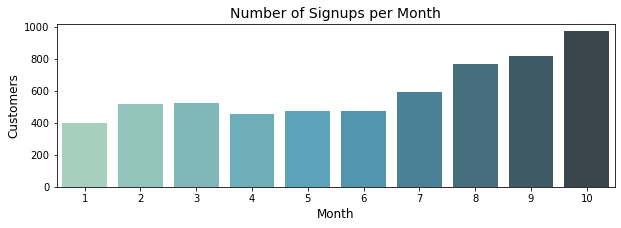

In [15]:
month = df.groupby('Month', as_index=False)['channel'].count().sort_values(by='channel', ascending=False)
plt.figure(figsize=(10,3))
ax3 = sns.barplot(x=month['Month'], y=month['channel'], palette='GnBu_d')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Customers', fontsize=12)
plt.title('Number of Signups per Month', fontsize=14)

In the heatmap below, we plot the number of people that joined getsafe by day of the week and hour.
We can the number of signups is very stable across the different days of the week and hour. There is more activity between 9 am and 7 pm, especially on Wednesday.
We can also see that on Monday at 11 am and Thursday from 11 am to 12 pm there was an increase in the number of signups.

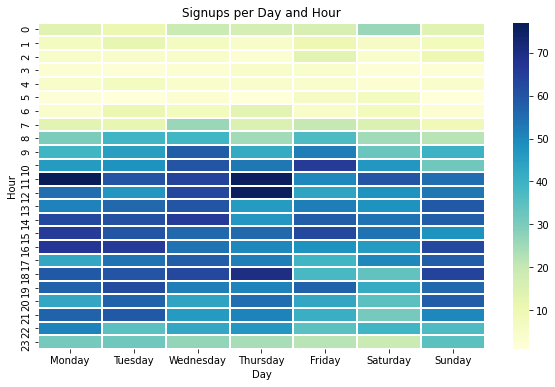

In [16]:
dfhm = df.groupby(['Day','Hour'])['channel'].count().reset_index()
dfhm.columns = ['Day','Hour','Customers']
dfhm['Day'] = pd.CategoricalIndex(dfhm['Day'], categories= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
#dfhm.sortlevel(level=0, inplace=True)

plt.figure(figsize=(10, 6))
hm = dfhm.pivot_table(index='Hour', columns='Day',values='Customers')

sns.heatmap( 
    hm, 
    cmap='YlGnBu',
    linecolor='white', 
    linewidth=1 
)

plt.title('Signups per Day and Hour')
plt.show() # Show 

We do a similar plot but this time we consider the number of conversions by day and hour.
We can see a similar patter by day and hour, however, there is an increase in conversions on Monday at 11 am

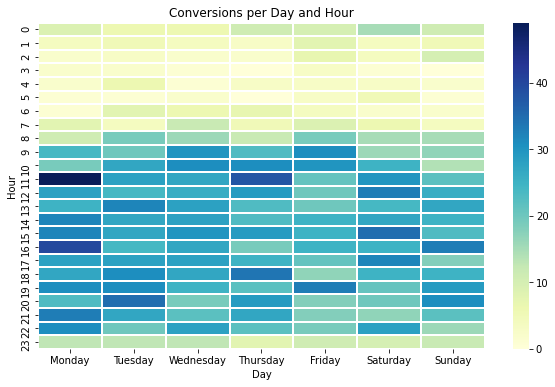

In [17]:
dfhm = df.groupby(['Day','Hour'])['converted'].sum().reset_index()
dfhm.columns = ['Day','Hour','Conversions']
dfhm['Day'] = pd.CategoricalIndex(dfhm['Day'], categories= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
#dfhm.sortlevel(level=0, inplace=True)

plt.figure(figsize=(10, 6))
hm = dfhm.pivot_table(index='Hour', columns='Day',values='Conversions')

sns.heatmap( 
    hm, 
    cmap='YlGnBu',
    linecolor='white', 
    linewidth=1 
)

plt.title('Conversions per Day and Hour')
plt.show() # Show 

On average, there are 18 conversions per day. Monday has the most number of conversions, while Friday and Sunday have the least. 

In [18]:
dfhm['Conversions'].describe()

count    168.000000
mean      17.857143
std       11.203766
min        0.000000
25%        6.000000
50%       20.000000
75%       27.000000
max       49.000000
Name: Conversions, dtype: float64

Text(0.5, 1.0, 'Number of conversions per day')

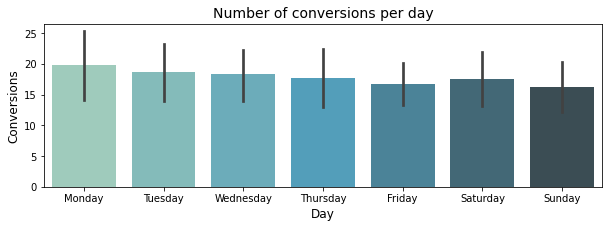

In [19]:
plt.figure(figsize=(10,3))
ax3 = sns.barplot(x=dfhm['Day'], y=dfhm['Conversions'], palette='GnBu_d')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Conversions', fontsize=12)
plt.title('Number of conversions per day', fontsize=14)

Now, we analise the conversions by channel. In the plot below, we can see that aggregator is tha channel with more conversions. 

Text(0.5, 1.0, 'Number of conversions by channel')

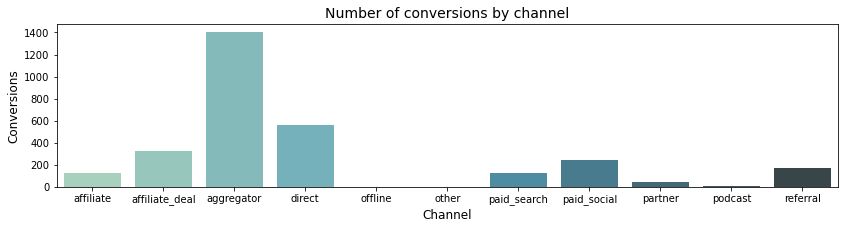

In [20]:
channel = df.groupby('channel', as_index=False)['converted'].sum()
plt.figure(figsize=(14,3))
ax3 = sns.barplot(x=channel['channel'], y=channel['converted'], palette='GnBu_d')
plt.xlabel('Channel', fontsize=12)
plt.ylabel('Conversions', fontsize=12)
plt.title('Number of conversions by channel', fontsize=14)

Liability is the insurance product that attracts more people to join getsafe.

Text(0.5, 1.0, 'Number of conversions by product')

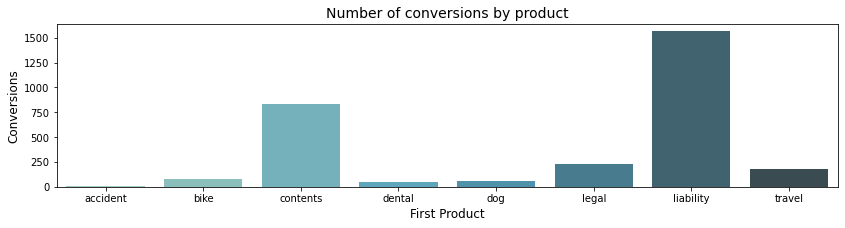

In [21]:
channel = df.groupby('first_product', as_index=False)['converted'].sum()
plt.figure(figsize=(14,3))
ax3 = sns.barplot(x=channel['first_product'], y=channel['converted'], palette='GnBu_d')
plt.xlabel('First Product', fontsize=12)
plt.ylabel('Conversions', fontsize=12)
plt.title('Number of conversions by product', fontsize=14)

Here we can see that the majority of the conversions for contents and liability come from aggregator. 

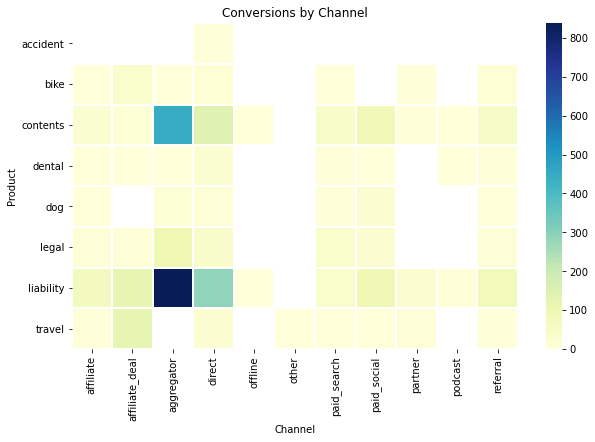

In [22]:
dfhm = df.groupby(['channel','first_product'])['converted'].sum().reset_index()
dfhm.columns = ['Channel','Product','Conversions']

plt.figure(figsize=(10, 6))
hm = dfhm.pivot_table(index='Product', columns='Channel',values='Conversions')

sns.heatmap( 
    hm, 
    cmap='YlGnBu',
    linecolor='white', 
    linewidth=1 
)

plt.title('Conversions by Channel')
plt.show() # Show 

We removed aggregator so that we can better analyse the conversions of other channels. In the heatmap below, we can see that affiliate deal drives more conversions to liability and travel, direct and paid social drive more conversions to contents and liability and referral to liability

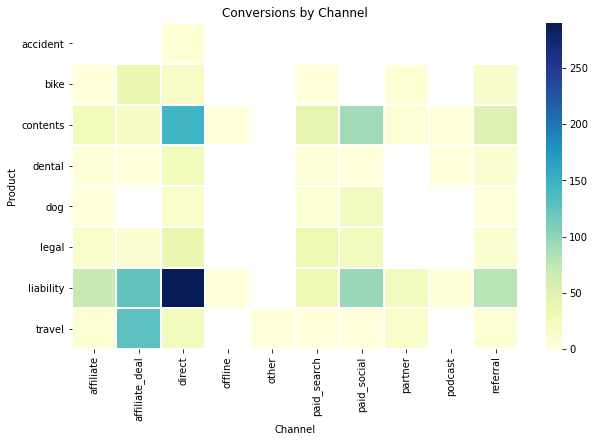

In [23]:
dfhm = df.groupby(['channel','first_product'])['converted'].sum().reset_index()
dfhm.columns = ['Channel','Product','Conversions']
dfhm = dfhm[dfhm['Channel'] != 'aggregator']
plt.figure(figsize=(10, 6))
hm = dfhm.pivot_table(index='Product', columns='Channel',values='Conversions')

sns.heatmap( 
    hm, 
    cmap='YlGnBu',
    linecolor='white', 
    linewidth=1 
)

plt.title('Conversions by Channel')
plt.show() # Show 

Web is the most popular buying platform (56%)

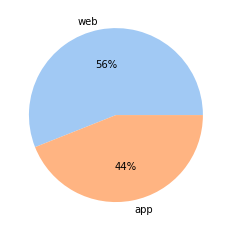

In [24]:
dfos = df[~df['buying_platform'].isnull()]

colors = sns.color_palette('pastel')[0:2]
datapie =  dfos['buying_platform'].value_counts()
labels =  dfos['buying_platform'].unique()
plt.pie(datapie, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

Rural area has more conversions followed by urban and big 7

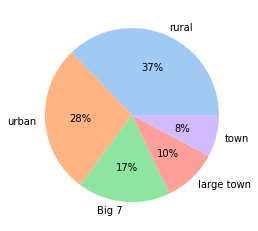

In [25]:
dfos = df[~df['area_classification'].isnull()]

colors = sns.color_palette('pastel')[0:5]
datapie =  dfos['area_classification'].value_counts()
labels =  dfos['area_classification'].unique()
plt.pie(datapie, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

Consumers living in rural, large town and big 7 areas convert more using the app than with the website.

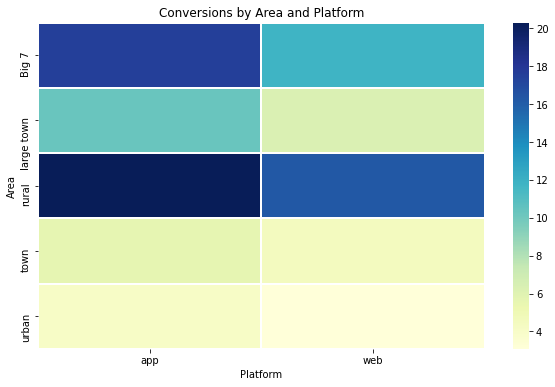

In [26]:
dfhm = dfos.groupby(['area_classification','buying_platform'])['converted'].sum().reset_index()
dfhm.columns = ['Area','Platform','Conversions']
dfhm['Percentage'] = (dfhm['Conversions'] / dfhm['Conversions'].sum())*100


plt.figure(figsize=(10, 6))
hm = dfhm.pivot_table(index='Area', columns='Platform',values='Percentage')

sns.heatmap( 
    hm, 
    cmap='YlGnBu',
    linecolor='white', 
    linewidth=1 
)

plt.title('Conversions by Area and Platform')
plt.show() # Show 

The youngest customer is 18 years old and the oldest one has 91. There is an error in line 2634 (the age is 2013), so we will remove this record from our dataset.
In the plot below, we can see that the graph is skewed to the left that means that the majority of the customers are young people, that is, customers between ages 25 - 37 are more intereted in buying insurance with getsafe.

In [27]:
df.age.describe()

count    6000.000000
mean       32.721833
std        27.635606
min        18.000000
25%        25.000000
50%        30.000000
75%        37.000000
max      2013.000000
Name: age, dtype: float64

In [29]:
df[df['age'] > 80]

,age,joined_getsafe_at,language,channel,first_product,zip_bucket,area_classification,most_used_os,buying_platform,converted,Year,Month,Hour,DayNumber,Day
1295,89,2020-09-16 09:58:06,de,aggregator,contents,125xx,rural,NaN,NaN,1,2020,9,9,2,Wednesday
1859,87,2020-10-21 11:57:35,de,aggregator,contents,152xx,town,NaN,NaN,0,2020,10,11,2,Wednesday
2325,91,2020-06-01 12:37:00,de,affiliate,liability,508xx,Big 7,Android,web,0,2020,6,12,0,Monday
2380,85,2020-07-03 20:24:08,de,aggregator,dog,131xx,Big 7,Android,NaN,0,2020,7,20,4,Friday
2634,2013,2020-02-26 14:36:36,en,paid_social,contents,891xx,rural,Android,NaN,0,2020,2,14,2,Wednesday
3690,82,2020-08-16 10:42:04,de,aggregator,contents,426xx,large town,iOS,NaN,0,2020,8,10,6,Sunday
4274,85,2020-09-22 09:22:01,de,aggregator,contents,249xx,town,NaN,NaN,1,2020,9,9,1,Tuesday
5671,83,2020-08-12 12:47:17,de,aggregator,contents,635xx,rural,NaN,NaN,0,2020,8,12,2,Wednesday
5794,83,2020-01-15 08:43:20,de,affiliate_deal,travel,765xx,NaN,Android,NaN,0,2020,1,8,2,Wednesday


In [30]:
df = df[df['age'] < 100].reset_index(drop = True)
df.head(3)

,age,joined_getsafe_at,language,channel,first_product,zip_bucket,area_classification,most_used_os,buying_platform,converted,Year,Month,Hour,DayNumber,Day
0,51,2020-04-21 18:19:07,de,paid_social,legal,539xx,rural,Android,web,1,2020,4,18,1,Tuesday
1,18,2020-08-09 20:14:37,de,direct,liability,305xx,urban,Android,app,1,2020,8,20,6,Sunday
2,20,2020-08-03 00:51:27,de,aggregator,liability,882xx,rural,Android,app,1,2020,8,0,0,Monday


Text(0, 0.5, 'Age Distribution')

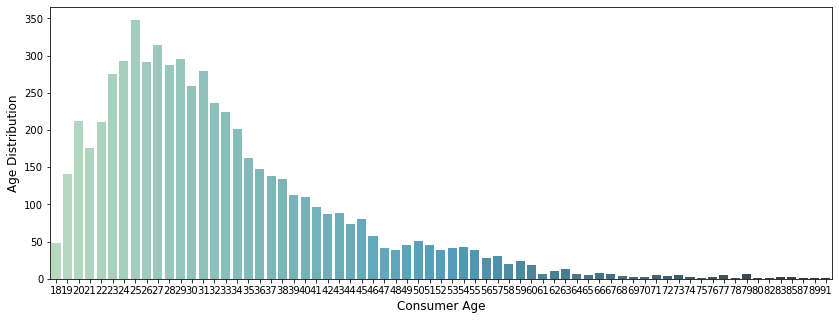

In [31]:
a = df.groupby('age')['converted'].count().reset_index()
plt.figure(figsize=(14,5))
ax = sns.barplot(x=a['age'],y = a['converted'], palette = 'GnBu_d')
plt.xlabel('Consumer Age',fontsize = 12)
plt.ylabel('Age Distribution',fontsize = 12)

There are 652 unique zip codes and it's very expensive to create dummy variables for each one. What we will do is to create groups depending on the sequence of the first digits.

In [32]:
np.unique(df.zip_bucket)[0:10]

array(['010xx', '011xx', '012xx', '013xx', '014xx', '015xx', '016xx',
       '017xx', '018xx', '019xx'], dtype=object)

In [33]:
len(np.unique(df.zip_bucket))

652

In [34]:
def zip_group_bucket(x):
    x = x.replace('xx','')
    x = int(x)
    if x < 100:
        zipcode = 0
    elif x >= 100 and x < 200:
        zipcode = 1
    elif x >= 200 and x < 300:
        zipcode = 2
    elif x >= 300 and x < 400:
        zipcode = 3
    elif x >= 400 and x < 500:
        zipcode = 4
    elif x >= 500 and x < 600:
        zipcode = 5
    elif x >= 600 and x < 700:
        zipcode = 6
    elif x >= 700 and x < 800:
        zipcode = 7
    elif x >= 800 and x < 800:
        zipcode = 8
    else:
        zipcode = 9
    return zipcode        

In [35]:
df['zip_bucket_group'] = df['zip_bucket'].apply(lambda x: zip_group_bucket(x))

Zip code group 1 and 9 have more consumers

Text(0, 0.5, 'Number of customers')

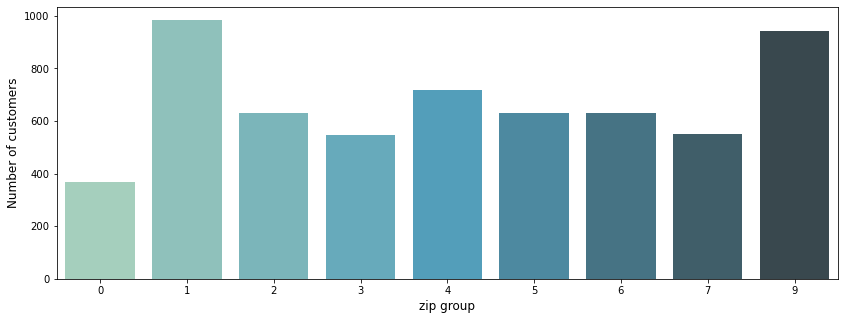

In [36]:
zc = df.groupby('zip_bucket_group')['zip_bucket'].count().reset_index()
plt.figure(figsize=(14,5))
ax = sns.barplot(x=zc['zip_bucket_group'],y = zc['zip_bucket'], palette = 'GnBu_d')
plt.xlabel('zip group',fontsize = 12)
plt.ylabel('Number of customers',fontsize = 12)

Let's check if there is a correlation between the zip codes and the insurance products

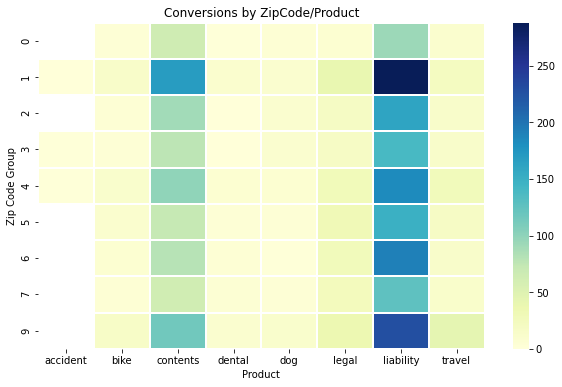

In [37]:
dfzc = df.groupby(['zip_bucket_group','first_product'])['converted'].sum().reset_index()
dfzc.columns = ['Zip Code Group','Product','Conversions']

plt.figure(figsize=(10, 6))
hm = dfzc.pivot_table(index='Zip Code Group', columns='Product',values='Conversions')

sns.heatmap( 
    hm, 
    cmap='YlGnBu',
    linecolor='white', 
    linewidth=1 
)

plt.title('Conversions by ZipCode/Product')
plt.show() # Show 

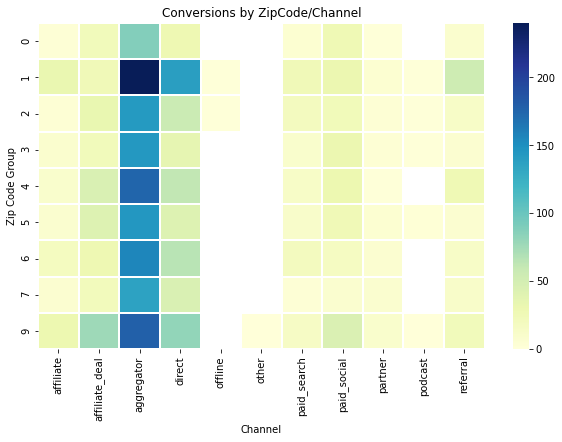

In [38]:
dfzc = df.groupby(['zip_bucket_group','channel'])['converted'].sum().reset_index()
dfzc.columns = ['Zip Code Group','Channel','Conversions']

plt.figure(figsize=(10, 6))
hm = dfzc.pivot_table(index='Zip Code Group', columns='Channel',values='Conversions')

sns.heatmap( 
    hm, 
    cmap='YlGnBu',
    linecolor='white', 
    linewidth=1 
)

plt.title('Conversions by ZipCode/Channel')
plt.show() # Show 

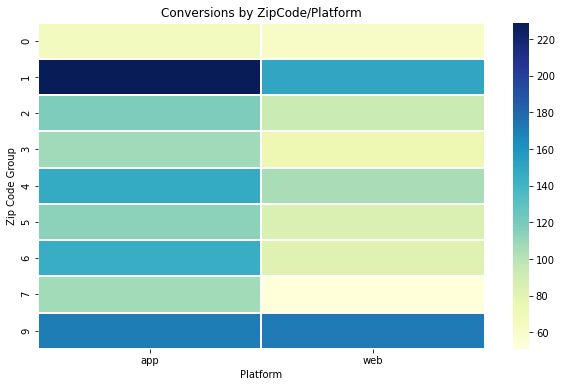

In [39]:
dfzc = df.groupby(['zip_bucket_group','buying_platform'])['converted'].sum().reset_index()
dfzc.columns = ['Zip Code Group','Platform','Conversions']

plt.figure(figsize=(10, 6))
hm = dfzc.pivot_table(index='Zip Code Group', columns='Platform',values='Conversions')

sns.heatmap( 
    hm, 
    cmap='YlGnBu',
    linecolor='white', 
    linewidth=1 
)

plt.title('Conversions by ZipCode/Platform')
plt.show() # Show 

The two most popular insurance products are contents and liability. Also aggregator is driving more conversions followed by direct. Both web and app are very popular en zip code group 9. In groups 2 to 7 app is more popular

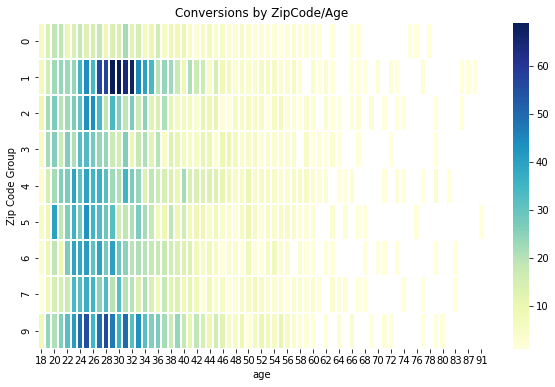

In [40]:
dfzc = df.groupby(['zip_bucket_group','age'])['converted'].count().reset_index()
dfzc.columns = ['Zip Code Group','age','Conversions']

plt.figure(figsize=(10, 6))
hm = dfzc.pivot_table(index='Zip Code Group', columns='age',values='Conversions')

sns.heatmap( 
    hm, 
    cmap='YlGnBu',
    linecolor='white', 
    linewidth=1 
)

plt.title('Conversions by ZipCode/Age')
plt.show() # Show 

In the heatmap above, we can see the distribution of consumer age by region. In region 1, we can see customers between ages 225 to 36. In region 9, we have a younger population from age 22 to 32.
Regions 2, 3, 4 and 5 are skewed to the left meaning that customers are less than 30 years old. 

In [42]:
buying_missing = df[df['buying_platform'].isnull()]
buying_missing.head()

,age,joined_getsafe_at,language,channel,first_product,zip_bucket,area_classification,most_used_os,buying_platform,converted,Year,Month,Hour,DayNumber,Day,zip_bucket_group
3,18,2020-10-24 13:07:40,de,aggregator,liability,986xx,rural,NaN,NaN,1,2020,10,13,5,Saturday,9
10,24,2020-09-29 21:32:12,de,aggregator,contents,249xx,rural,Android,NaN,1,2020,9,21,1,Tuesday,2
13,32,2020-05-21 10:24:06,de,aggregator,liability,165xx,rural,iOS,NaN,1,2020,5,10,3,Thursday,1
14,34,2020-03-19 11:30:28,de,aggregator,contents,922xx,rural,Android,NaN,1,2020,3,11,3,Thursday,9
19,20,2020-08-07 11:34:23,de,aggregator,liability,317xx,town,iOS,NaN,1,2020,8,11,4,Friday,3


In [43]:
buying_missing.groupby(['channel'])['joined_getsafe_at'].count().reset_index()

,channel,joined_getsafe_at
0,affiliate,106
1,affiliate_deal,233
2,aggregator,2397
3,direct,63
4,other,1
5,paid_search,8
6,paid_social,5
7,partner,16
8,podcast,1
9,referral,41


First we will create categorical labels for buying_platform and we will predict label for missing values

In [44]:
encoder = LabelEncoder()
df['buying_platform_cat'] = encoder.fit_transform(df['buying_platform'])

In [45]:
np.unique(df['buying_platform_cat'])

array([0, 1, 2])

In [46]:
df.head(5)

,age,joined_getsafe_at,language,channel,first_product,zip_bucket,area_classification,most_used_os,buying_platform,converted,Year,Month,Hour,DayNumber,Day,zip_bucket_group,buying_platform_cat
0,51,2020-04-21 18:19:07,de,paid_social,legal,539xx,rural,Android,web,1,2020,4,18,1,Tuesday,5,1
1,18,2020-08-09 20:14:37,de,direct,liability,305xx,urban,Android,app,1,2020,8,20,6,Sunday,3,0
2,20,2020-08-03 00:51:27,de,aggregator,liability,882xx,rural,Android,app,1,2020,8,0,0,Monday,9,0
3,18,2020-10-24 13:07:40,de,aggregator,liability,986xx,rural,NaN,NaN,1,2020,10,13,5,Saturday,9,2
4,28,2020-05-31 22:54:47,de,direct,liability,104xx,Big 7,Android,app,1,2020,5,22,6,Sunday,1,0


In [47]:
train_missing = df[~df['buying_platform'].isnull()]
test_missing = df[df['buying_platform'].isnull()]

We remove our target variable

In [48]:
X_train_ensemble = train_missing.drop(['Day','zip_bucket','joined_getsafe_at','Year','converted','buying_platform','buying_platform_cat'], axis = 1)
y_train_ensemble = train_missing['buying_platform_cat']

X_test_ensemble = test_missing.drop(['Day','zip_bucket','joined_getsafe_at','Year','converted','buying_platform','buying_platform_cat'], axis = 1)
y_test_ensemble = test_missing['buying_platform_cat']

In [49]:
X_train_ensemble.head(3)

,age,language,channel,first_product,area_classification,most_used_os,Month,Hour,DayNumber,zip_bucket_group
0,51,de,paid_social,legal,rural,Android,4,18,1,5
1,18,de,direct,liability,urban,Android,8,20,6,3
2,20,de,aggregator,liability,rural,Android,8,0,0,9


In [50]:
dummy_list = ['language','channel','first_product','area_classification','most_used_os']

X_train_ensemble = pd.get_dummies(X_train_ensemble, columns=dummy_list, drop_first=True)
X_test_ensemble = pd.get_dummies(X_test_ensemble, columns=dummy_list, drop_first=True)

In [51]:
X_train_ensemble.head(3)

,age,Month,Hour,DayNumber,zip_bucket_group,language_en,channel_affiliate_deal,channel_aggregator,channel_direct,channel_offline,...,first_product_dental,first_product_dog,first_product_legal,first_product_liability,first_product_travel,area_classification_large town,area_classification_rural,area_classification_town,area_classification_urban,most_used_os_iOS
0,51,4,18,1,5,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,18,8,20,6,3,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,20,8,0,0,9,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0


In [52]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

n_estimators = 10
max_depth = 5

random_forest = RandomForestClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10
)

random_forest.fit(X_train_ensemble, y_train_ensemble)

gradient_boosting = GradientBoostingClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10
)

_ = gradient_boosting.fit(X_train_ensemble, y_train_ensemble)

In [53]:
predict_train = gradient_boosting.predict(X_train_ensemble)

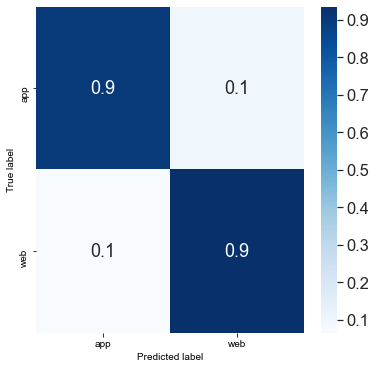

In [54]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

class_names = np.unique(y_train_ensemble)
target_names = pd.Series(class_names).map({0.: 'app',1.:'web'})

cm = confusion_matrix(y_train_ensemble, predict_train)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale = 1.5)
sns.heatmap(cmn, annot=True, fmt='.1f', xticklabels=target_names, yticklabels=target_names,cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show(block=False)

In [55]:
predict_test = gradient_boosting.predict(X_test_ensemble)

In [56]:
test_missing = test_missing.drop(['buying_platform_cat'],axis=1)

In [57]:
test_missing = test_missing.reset_index(drop=True)
test_missing['buying_platform_cat'] = pd.DataFrame(predict_test)

In [58]:
train_missing = train_missing.reset_index(drop=True)

In [59]:
dfnew = train_missing.append([test_missing]).reset_index(drop=True)
dfnew.head(3)

,age,joined_getsafe_at,language,channel,first_product,zip_bucket,area_classification,most_used_os,buying_platform,converted,Year,Month,Hour,DayNumber,Day,zip_bucket_group,buying_platform_cat
0,51,2020-04-21 18:19:07,de,paid_social,legal,539xx,rural,Android,web,1,2020,4,18,1,Tuesday,5,1
1,18,2020-08-09 20:14:37,de,direct,liability,305xx,urban,Android,app,1,2020,8,20,6,Sunday,3,0
2,20,2020-08-03 00:51:27,de,aggregator,liability,882xx,rural,Android,app,1,2020,8,0,0,Monday,9,0


In [60]:
dfnew['age_group'] = pd.DataFrame(pd.qcut(dfnew['age'],5,labels= False))

In [61]:
dfnew.columns

Index(['age', 'joined_getsafe_at', 'language', 'channel', 'first_product',
       'zip_bucket', 'area_classification', 'most_used_os', 'buying_platform',
       'converted', 'Year', 'Month', 'Hour', 'DayNumber', 'Day',
       'zip_bucket_group', 'buying_platform_cat', 'age_group'],
      dtype='object')

In [67]:
dfconverted = dfnew[['age_group', 'language', 'channel', 'first_product',
        'area_classification', 'most_used_os',
       'converted', 'Month', 'Hour', 'DayNumber',
       'zip_bucket_group', 'buying_platform_cat']]

In [68]:
cols = ['age_group', 'language', 'channel', 'first_product',
        'area_classification', 'most_used_os','Month', 'Hour', 'DayNumber',
       'zip_bucket_group', 'buying_platform_cat']
dfconverted = pd.get_dummies(dfconverted, columns=cols, drop_first=True)

In [69]:
dfconverted.head(5)

,converted,age_group_1,age_group_2,age_group_3,age_group_4,language_en,channel_affiliate_deal,channel_aggregator,channel_direct,channel_offline,...,DayNumber_6,zip_bucket_group_1,zip_bucket_group_2,zip_bucket_group_3,zip_bucket_group_4,zip_bucket_group_5,zip_bucket_group_6,zip_bucket_group_7,zip_bucket_group_9,buying_platform_cat_1
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0
4,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

X = dfconverted.drop(['converted'], axis = 1)
y = dfconverted['converted']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2)

In [97]:
# Build the model with the random forest algorithm:

n_estimators = 200
max_depth = 10

random_forest = RandomForestClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10
)

random_forest.fit(X_train, Y_train)

gradient_boosting = GradientBoostingClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10
)

_ = gradient_boosting.fit(X_train, Y_train)

In [98]:
predict_train = gradient_boosting.predict(X_train)
predict_test = gradient_boosting.predict(X_test)

In [99]:
accuracy_score(Y_train, predict_train)

0.9987497395290685

In [100]:
accuracy_score(Y_test, predict_test)

0.6366666666666667

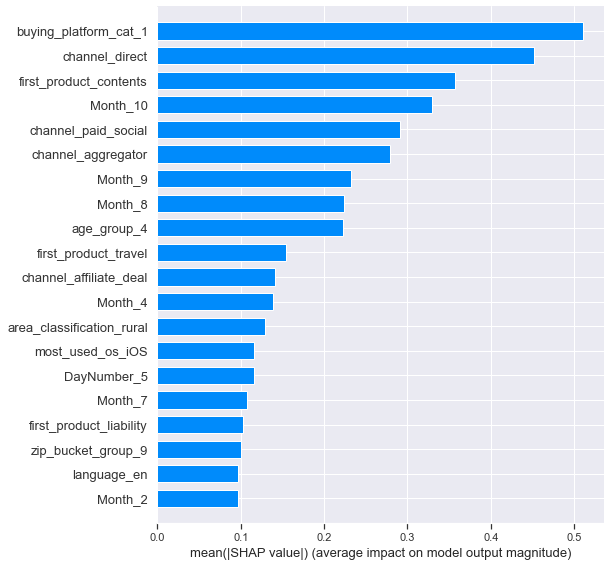

In [101]:
import shap 

shap_values = shap.TreeExplainer(gradient_boosting).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [103]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Build a pipeline object
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier())
])

# Declare a hyperparameter grid
param_grid = {
    "clf__n_estimators": [100, 500, 1000],
    "clf__max_depth": [1, 5, 8, 10,15,20, 25],
    "clf__max_features": [*np.arange(0.1, 1.1, 0.1)],
}

# Perform grid search, fit it, and print score
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1000)
gs.fit(X_train, Y_train)


Fitting 3 folds for each of 210 candidates, totalling 630 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [1, 5, 8, 10, 15, 20, 25],
                         'clf__max_features': [0.1, 0.2, 0.30000000000000004,
                                               0.4, 0.5, 0.6,
                                               0.7000000000000001, 0.8, 0.9,
                                               1.0],
                         'clf__n_estimators': [100, 500, 1000]},
             verbose=1000)

In [104]:
predict_train = gs.predict(X_train)
accuracy_score(Y_train, predict_train)

0.8945613669514482

In [105]:
predict_test = gs.predict(X_test)
accuracy_score(Y_test, predict_test)

0.6441666666666667

In [109]:
importances = gs.best_estimator_.named_steps["clf"].feature_importances_
indices = np.argsort(importances)

In [116]:
feature_importance = pd.DataFrame(X_train.columns,columns = ['Features'])
feature_importance['Coefficient']= pd.DataFrame(importances)
feature_importance

,Features,Coefficient
0,age_group_1,0.018984
1,age_group_2,0.017386
2,age_group_3,0.018588
3,age_group_4,0.022873
4,language_en,0.019407
...,...,...
70,zip_bucket_group_5,0.012815
71,zip_bucket_group_6,0.012747
72,zip_bucket_group_7,0.012939
73,zip_bucket_group_9,0.018213


In [122]:
feature_importance = feature_importance.sort_values(by=['Coefficient'], ascending=False)

Text(0, 0.5, 'Feature')

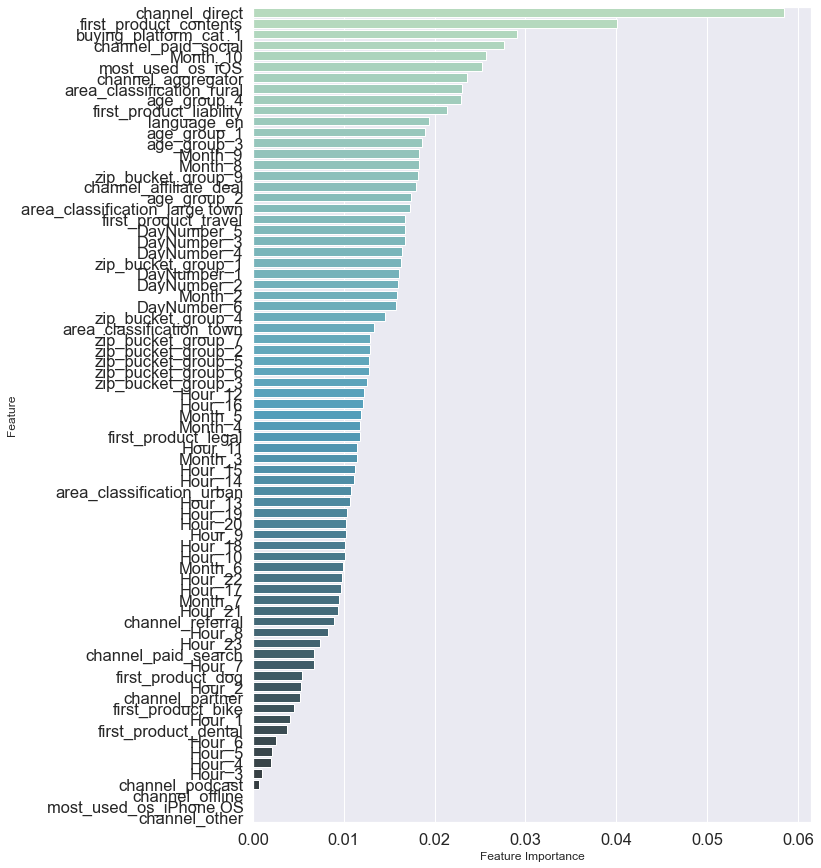

In [131]:
plt.figure(figsize=(10,15))
ax = sns.barplot(x=feature_importance['Coefficient'],y = feature_importance['Features'], palette = 'GnBu_d')
plt.xlabel('Feature Importance',fontsize = 12)
plt.ylabel('Feature',fontsize = 12)